# Aprendizaje semi-supervisado

**Integrantes:**
-  Jaime Uribe — jruribem@eafit.edu.co
- Luis Miguel Giraldo — lmgiraldo@eafit.edu.co
- Sofía Zapata — szapata@eafit.edu.co


**Profesor:** Marco Terán  
**Fecha:** 2025

___


TABLA DE CONTENIDOS:
1. Introducción al Aprendizaje Semi-Supervisado
2. Configuración del Entorno
3. Ejemplo 1: Self-Training (Auto-entrenamiento)
4. Ejemplo 2: Label Propagation (Propagación de Etiquetas)
5. Comparación de Modelos Semi-Supervisados
6. Conclusiones y Mejores Prácticas
7. Referencias y Recursos


¿Qué es el Aprendizaje Semi-Supervisado?

El aprendizaje semi-supervisado es un paradigma de machine learning que combina:
- POCOS datos ETIQUETADOS (labeled): datos con sus respuestas conocidas
- MUCHOS datos SIN ETIQUETAR (unlabeled): datos sin respuestas conocidas

El objetivo es aprovechar los datos sin etiquetar para mejorar el rendimiento
del modelo más allá de lo que se podría lograr solo con los datos etiquetados.

 Diferencias con otros paradigmas

| **Paradigma**        | **Datos etiquetados** | **Datos sin etiquetar** | **Objetivo principal** |
|-----------------------|-----------------------|--------------------------|-------------------------|
| Supervisado           | Todos                 | Ninguno                 | Clasificar o predecir   |
| No supervisado        | Ninguno               | Todos                   | Agrupar o reducir       |
| Semi-supervisado      | Pocos                 | Muchos                  | Clasificar mejor        |


¿Cuándo usar aprendizaje semi-supervisado?

1. Etiquetar datos es COSTOSO (tiempo, dinero, expertos)
   - Diagnóstico médico (requiere doctores)
   - Análisis legal (requiere abogados)
   - Clasificación de imágenes (requiere anotadores)

2. Tenemos MUCHOS datos sin etiquetar disponibles
   - Texto de internet
   - Imágenes de cámaras
   - Datos de sensores

3. Los datos sin etiquetar contienen INFORMACIÓN ÚTIL sobre la estructura


Objetivos de este notebook:
- Implementar técnicas de Self-Training y Label Propagation
- Demostrar cómo datos sin etiquetar mejoran el rendimiento
- Comparar con modelos puramente supervisados
- Proporcionar código reproducible y bien documentado


# Importación de librerías necesarias

In [16]:
# Importación de librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
import warnings
from sklearn.exceptions import ConvergenceWarning
# Modelos supervisados base
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Modelos semi-supervisados
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

# Datasets
from sklearn.datasets import load_digits, make_moons

# Configuración para reproducibilidad
SEED = 42
np.random.seed(SEED)

# Configuración de visualizaciones
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Verificación de versiones
print("=" * 60)
print("CONFIGURACIÓN DEL ENTORNO - APRENDIZAJE SEMI-SUPERVISADO")
print("=" * 60)
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print("Scikit-learn: Módulos semi-supervisados disponibles")
print(f"Semilla aleatoria: {SEED}")
print("=" * 60)

# Función auxiliar para simular escenario semi-supervisado
def crear_dataset_semisupervisado(X, y, n_labeled, random_state=SEED):
    """
    Simula un escenario semi-supervisado marcando solo n_labeled ejemplos.
    Los ejemplos no etiquetados se marcan con -1.

    Parámetros:
    X : array, features
    y : array, etiquetas verdaderas
    n_labeled : int, número de ejemplos a etiquetar
    random_state : int, semilla aleatoria

    Retorna:
    --------
    y_semi : array, etiquetas con -1 para ejemplos sin etiquetar
    indices_labeled : array, índices de los ejemplos etiquetados
    """
    rng = np.random.RandomState(random_state)
    y_semi = np.copy(y)

    # Seleccionar aleatoriamente qué ejemplos etiquetar
    indices_labeled = rng.choice(len(y), n_labeled, replace=False)

    # Marcar el resto como sin etiquetar (-1)
    mask = np.ones(len(y), dtype=bool)
    mask[indices_labeled] = False
    y_semi[mask] = -1

    print(f"Dataset semi-supervisado creado:")
    print(f"  - Total de ejemplos: {len(y)}")
    print(f"  - Ejemplos ETIQUETADOS: {n_labeled} ({n_labeled/len(y)*100:.1f}%)")
    print(f"  - Ejemplos SIN ETIQUETAR: {len(y) - n_labeled} ({(len(y)-n_labeled)/len(y)*100:.1f}%)")

    return y_semi, indices_labeled

CONFIGURACIÓN DEL ENTORNO - APRENDIZAJE SEMI-SUPERVISADO
NumPy version: 2.0.2
Pandas version: 2.2.2
Scikit-learn: Módulos semi-supervisados disponibles ✓
Semilla aleatoria: 42


## EJEMPLO 1: SELF-TRAINING (AUTO-ENTRENAMIENTO)

Características del dataset:
  - Muestras totales: 1797
  - Features: 64 (imágenes 8x8 pixeles)
  - Clases: 10 dígitos (0-9)

División de datos:
  - Entrenamiento: 1257 muestras
  - Prueba: 540 muestras

 Creando escenario semi-supervisado
Dataset semi-supervisado creado:
  - Total de ejemplos: 1257
  - Ejemplos ETIQUETADOS: 62 (4.9%)
  - Ejemplos SIN ETIQUETAR: 1195 (95.1%)

 Entrenando modelo SUPERVISADO  (solo datos etiquetados)
Accuracy SUPERVISADO (solo 62 ejemplos): 0.7741

 Entrenando modelo SELF-TRAINING
End of iteration 1, added 131 new labels.
End of iteration 2, added 207 new labels.
End of iteration 3, added 218 new labels.
End of iteration 4, added 209 new labels.
End of iteration 5, added 113 new labels.
End of iteration 6, added 96 new labels.
End of iteration 7, added 59 new labels.
End of iteration 8, added 52 new labels.
End of iteration 9, added 15 new labels.
End of iteration 10, added 7 new labels.

✓ Accuracy SELF-TRAINING: 0.6426

 MEJORA con Self-Training: -16.9

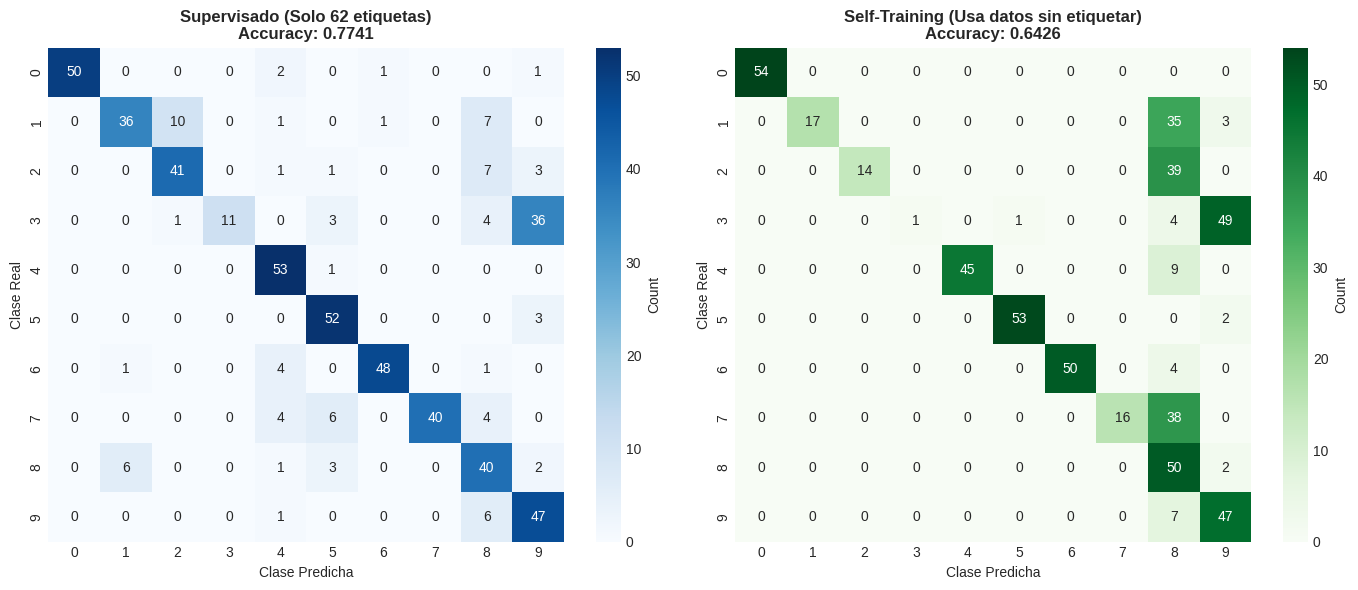

In [14]:
"""
Self-Training es una técnica iterativa:

1. Entrenar modelo con datos etiquetados (pocos)
2. Predecir etiquetas para datos sin etiquetar
3. Seleccionar predicciones MÁS CONFIABLES
4. Agregar esas predicciones al conjunto de entrenamiento
5. Repetir hasta que no haya más datos o se alcance un criterio
"""

# Cargamos los datos
# Usamos un subset del dataset MNIST de dígitos escritos a mano
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

print(f"Características del dataset:")
print(f"  - Muestras totales: {X_digits.shape[0]}")
print(f"  - Features: {X_digits.shape[1]} (imágenes 8x8 pixeles)")
print(f"  - Clases: {len(np.unique(y_digits))} dígitos (0-9)")

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X_digits, y_digits,
    test_size=0.3,
    random_state=SEED,
    stratify=y_digits
)

print(f"\nDivisión de datos:")
print(f"  - Entrenamiento: {len(X_train)} muestras")
print(f"  - Prueba: {len(X_test)} muestras")

# Normalizar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Crear escenario semi-supervisado

print("\n Creando escenario semi-supervisado")
# Simular que solo tenemos 5% de datos etiquetados,
# garantizando al menos 1 ejemplo por clase para evitar clases sin representación
n_labeled_raw = int(0.05 * len(X_train))  # Solo 5% etiquetado
n_classes = len(np.unique(y_train))
n_labeled = max(n_labeled_raw, n_classes)

y_train_semi, indices_labeled = crear_dataset_semisupervisado(
    X_train_scaled, y_train, n_labeled
)

# Modelo supervisado baseline (solo datos etiquetados)


print("\n Entrenando modelo SUPERVISADO  (solo datos etiquetados)")
# Clasificador con balanceo para reducir clases sin predicciones
clf_supervised = SVC(
    kernel='rbf',
    gamma='scale',
    probability=True,
    class_weight='balanced',
    random_state=SEED
)
clf_supervised.fit(
    X_train_scaled[indices_labeled],
    y_train[indices_labeled]
)

y_pred_supervised = clf_supervised.predict(X_test_scaled)
acc_supervised = accuracy_score(y_test, y_pred_supervised)
print(f"Accuracy SUPERVISADO (solo {n_labeled} ejemplos): {acc_supervised:.4f}")

# Modelo Self-Training

print("\n Entrenando modelo SELF-TRAINING")

# Crear clasificador Self-Training
# threshold controla qué tan confiable debe ser una predicción para aceptarla
clf_self_training = SelfTrainingClassifier(
    estimator=SVC(
        kernel='rbf',
        gamma='scale',
        probability=True,
        class_weight='balanced',  # ayuda con clases menos frecuentes
        random_state=SEED
    ),
    threshold=0.65,              # aceptar ejemplos con ≥65% confianza (más cobertura)
    criterion='threshold',       # usar threshold para seleccionar ejemplos
    max_iter=10,                 # máximo 10 iteraciones
    verbose=True
)

# Entrenar con datos semi-supervisados (-1 indica sin etiquetar)
clf_self_training.fit(X_train_scaled, y_train_semi)

# Evaluar
y_pred_self = clf_self_training.predict(X_test_scaled)
acc_self = accuracy_score(y_test, y_pred_self)
print(f"\n Accuracy SELF-TRAINING: {acc_self:.4f}")

# Calcular mejora
mejora = (acc_self - acc_supervised) / max(acc_supervised, 1e-12) * 100
print(f"\n MEJORA con Self-Training: {mejora:+.2f}%")
print(f"   Supervisado: {acc_supervised:.4f}")
print(f"   Self-Training: {acc_self:.4f}")

# Información sobre el proceso de self-training
n_iter = clf_self_training.n_iter_
termination = clf_self_training.termination_condition_
print(f"\n Detalles del proceso:")
print(f"   - Iteraciones realizadas: {n_iter}")
print(f"   - Condición de término: {termination}")

# Visualización de resultados

# Usamos etiquetas explícitas para mantener consistencia en la matriz de confusión
all_labels = list(range(10))

cm_self = confusion_matrix(y_test, y_pred_self, labels=all_labels)
cm_sup = confusion_matrix(y_test, y_pred_supervised, labels=all_labels)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Matriz de confusión - Supervisado
sns.heatmap(
    cm_sup,
    annot=True, fmt='d', cmap='Blues',
    ax=axes[0], cbar_kws={'label': 'Count'}
)
axes[0].set_title(f'Supervisado (Solo {n_labeled} etiquetas)\nAccuracy: {acc_supervised:.4f}',
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Clase Real')
axes[0].set_xlabel('Clase Predicha')

# Matriz de confusión - Self-Training
sns.heatmap(
    cm_self,
    annot=True, fmt='d', cmap='Greens',
    ax=axes[1], cbar_kws={'label': 'Count'}
)
axes[1].set_title(f'Self-Training (Usa datos sin etiquetar)\nAccuracy: {acc_self:.4f}',
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('Clase Real')
axes[1].set_xlabel('Clase Predicha')

plt.tight_layout()
plt.savefig('self_training_comparison.png', dpi=300, bbox_inches='tight')
print("\n Gráfico guardado como 'self_training_comparison.png'")

# Reporte de clasificación
print("\n Reporte detallado - Self-Training:")
print(classification_report(
    y_test,
    y_pred_self,
    labels=all_labels,
    target_names=[str(i) for i in all_labels],
    zero_division=0  # evita warnings asignando 0 cuando no hay predicciones para una clase
))


## EJEMPLO 2: LABEL PROPAGATION

Dataset creado:
  - Entrenamiento: 210 muestras
  - Prueba: 90 muestras
  - Clases: 2 (clasificación binaria)

 Creando escenario semi-supervisado
Dataset semi-supervisado creado:
  - Total de ejemplos: 210
  - Ejemplos ETIQUETADOS: 21 (10.0%)
  - Ejemplos SIN ETIQUETAR: 189 (90.0%)

Entrenando modelo SUPERVISADO baseline
✓ Accuracy SUPERVISADO (solo 21 ejemplos): 0.9000

 Entrenando modelo LABEL PROPAGATION...
✓ Accuracy LABEL PROPAGATION: 1.0000

MEJORA con Label Propagation: +11.11%
   Supervisado: 0.9000
   Label Propagation: 1.0000

Iteraciones hasta convergencia: 90

Generando visualización de fronteras de decisión...
✓ Gráfico guardado como 'label_propagation_boundary.png'

 Distribución de probabilidades calculada para 210 puntos


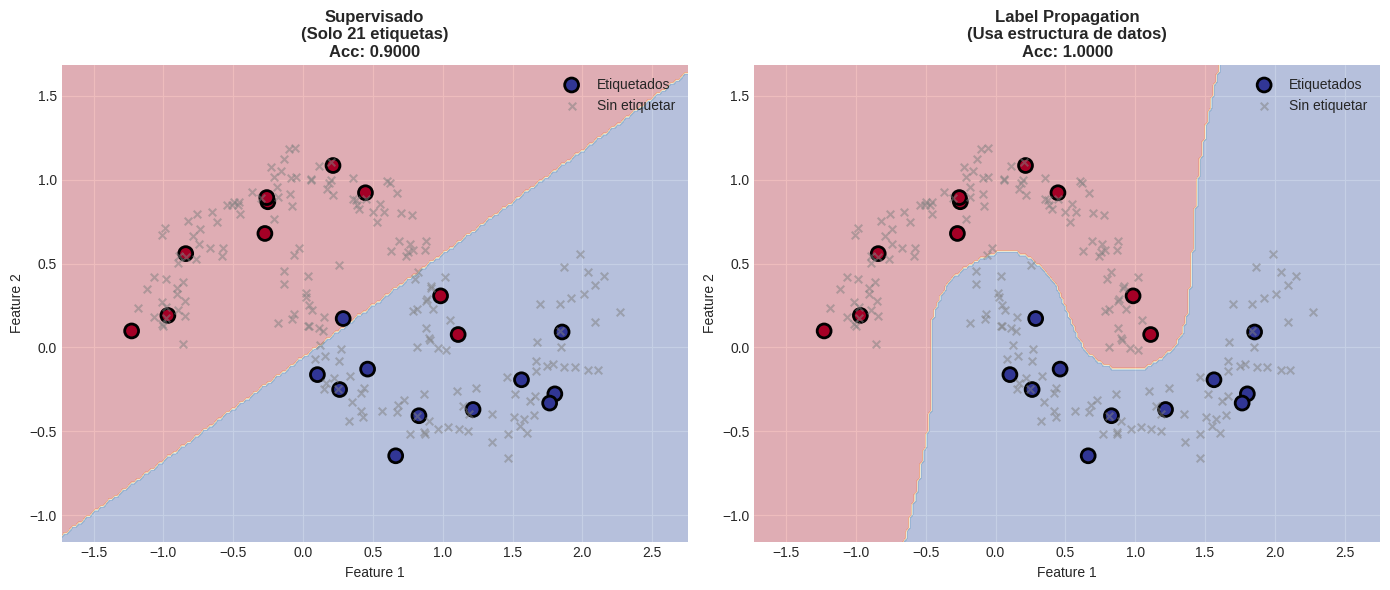

In [12]:
"""
Label Propagation es un método basado en grafos:

1. Construir un grafo de similitud entre todos los puntos
2. Las etiquetas se propagan a través de las conexiones
3. Puntos similares (cercanos) tienden a compartir etiquetas
4. Usa la estructura de los datos sin etiquetar

Ventajas:
- No requiere iteraciones (solución cerrada)
- Usa toda la estructura de datos
- Muy efectivo cuando suposición de smoothness se cumple

Desventajas:
- Computacionalmente costoso para datasets grandes
- Requiere construir matriz de similitud
- Sensible a parámetros de kernel
"""

# Crear dataset en forma de dos lunas entrelazadas
X_moons, y_moons = make_moons(n_samples=300, noise=0.1, random_state=SEED)

# Dividir en train/test
X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(
    X_moons, y_moons, test_size=0.3, random_state=SEED
)

print(f"Dataset creado:")
print(f"  - Entrenamiento: {len(X_train_moons)} muestras")
print(f"  - Prueba: {len(X_test_moons)} muestras")
print(f"  - Clases: 2 (clasificación binaria)")

# Crear escenario semi-supervisado


print("\n Creando escenario semi-supervisado")
# Solo etiquetar 10% de los datos
n_labeled_moons = int(0.10 * len(X_train_moons))
y_train_moons_semi, indices_labeled_moons = crear_dataset_semisupervisado(
    X_train_moons, y_train_moons, n_labeled_moons
)

# Modelo supervisado baseline


print("\nEntrenando modelo SUPERVISADO baseline")
clf_supervised_moons = LogisticRegression(random_state=SEED)
clf_supervised_moons.fit(
    X_train_moons[indices_labeled_moons],
    y_train_moons[indices_labeled_moons]
)

y_pred_sup_moons = clf_supervised_moons.predict(X_test_moons)
acc_sup_moons = accuracy_score(y_test_moons, y_pred_sup_moons)
print(f" Accuracy SUPERVISADO (solo {n_labeled_moons} ejemplos): {acc_sup_moons:.4f}")

# Modelo Label Propagation


print("\n Entrenando modelo LABEL PROPAGATION...")
# Las etiquetas se propagarán a través del grafo de similitud

# Label Propagation con kernel RBF (Gaussian)
clf_label_prop = LabelPropagation(
    kernel='rbf',  #
    gamma=20,  # Controla el alcance de la influencia
    max_iter=1000,
    tol=1e-3
)

# Entrenar con todos los datos (etiquetados y no etiquetados)
clf_label_prop.fit(X_train_moons, y_train_moons_semi)

# Evaluar
y_pred_lp_moons = clf_label_prop.predict(X_test_moons)
acc_lp_moons = accuracy_score(y_test_moons, y_pred_lp_moons)
print(f" Accuracy LABEL PROPAGATION: {acc_lp_moons:.4f}")

# Calcular mejora
mejora_lp = (acc_lp_moons - acc_sup_moons) / acc_sup_moons * 100
print(f"\nMEJORA con Label Propagation: {mejora_lp:+.2f}%")
print(f"   Supervisado: {acc_sup_moons:.4f}")
print(f"   Label Propagation: {acc_lp_moons:.4f}")

# Información sobre convergencia
n_iter_lp = clf_label_prop.n_iter_
print(f"\nIteraciones hasta convergencia: {n_iter_lp}")


# Visualización de fronteras de decisión

print("\nGenerando visualización de fronteras de decisión")

def plot_decision_boundary(clf, X, y, y_semi, indices_labeled, title, ax):
    """
    Plotea la frontera de decisión del clasificador.
    """
    h = 0.02  # Tamaño de paso en la malla
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predecir para cada punto en la malla
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plotear frontera
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')

    # Plotear puntos etiquetados (grandes)
    labeled_mask = y_semi != -1
    ax.scatter(X[labeled_mask, 0], X[labeled_mask, 1],
               c=y[labeled_mask], cmap='RdYlBu',
               s=100, edgecolor='black', linewidth=2,
               label='Etiquetados', marker='o')

    # Plotear puntos sin etiquetar (pequeños)
    unlabeled_mask = y_semi == -1
    ax.scatter(X[unlabeled_mask, 0], X[unlabeled_mask, 1],
               c='gray', s=30, alpha=0.5,
               label='Sin etiquetar', marker='x')

    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

# Crear visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Supervisado
plot_decision_boundary(
    clf_supervised_moons,
    X_train_moons,
    y_train_moons,
    y_train_moons_semi,
    indices_labeled_moons,
    f'Supervisado\n(Solo {n_labeled_moons} etiquetas)\nAcc: {acc_sup_moons:.4f}',
    axes[0]
)

# Label Propagation
plot_decision_boundary(
    clf_label_prop,
    X_train_moons,
    y_train_moons,
    y_train_moons_semi,
    indices_labeled_moons,
    f'Label Propagation\n(Usa estructura de datos)\nAcc: {acc_lp_moons:.4f}',
    axes[1]
)

plt.tight_layout()
plt.savefig('label_propagation_boundary.png', dpi=300, bbox_inches='tight')
print(" Gráfico guardado como 'label_propagation_boundary.png'")

# Distribución de probabilidades predichas
label_distributions = clf_label_prop.label_distributions_
print(f"\n Distribución de probabilidades calculada para {label_distributions.shape[0]} puntos")


# COMPARACIÓN DE MODELOS SEMI-SUPERVISADOS

Dataset semi-supervisado creado:
  - Total de ejemplos: 1257
  - Ejemplos ETIQUETADOS: 12 (1.0%)
  - Ejemplos SIN ETIQUETAR: 1245 (99.0%)
Probando con 1% de datos etiquetados (12 ejemplos)
  Supervisado:         0.1704
  Self-Training:       0.1704 (+0.0%)
  Label Propagation:   0.5204 (+35.0%)
  Label Spreading:     0.6185 (+44.8%)
Dataset semi-supervisado creado:
  - Total de ejemplos: 1257
  - Ejemplos ETIQUETADOS: 25 (2.0%)
  - Ejemplos SIN ETIQUETAR: 1232 (98.0%)
Probando con 2% de datos etiquetados (25 ejemplos)
  Supervisado:         0.4148
  Self-Training:       0.4148 (+0.0%)
  Label Propagation:   0.7185 (+30.4%)
  Label Spreading:     0.8204 (+40.6%)
Dataset semi-supervisado creado:
  - Total de ejemplos: 1257
  - Ejemplos ETIQUETADOS: 62 (4.9%)
  - Ejemplos SIN ETIQUETAR: 1195 (95.1%)
Probando con 5% de datos etiquetados (62 ejemplos)
  Supervisado:         0.6778
  Self-Training:       0.6889 (+1.1%)
  Label Propagation:   0.8167 (+13.9%)
  Label Spreading:     0.8907 (+21

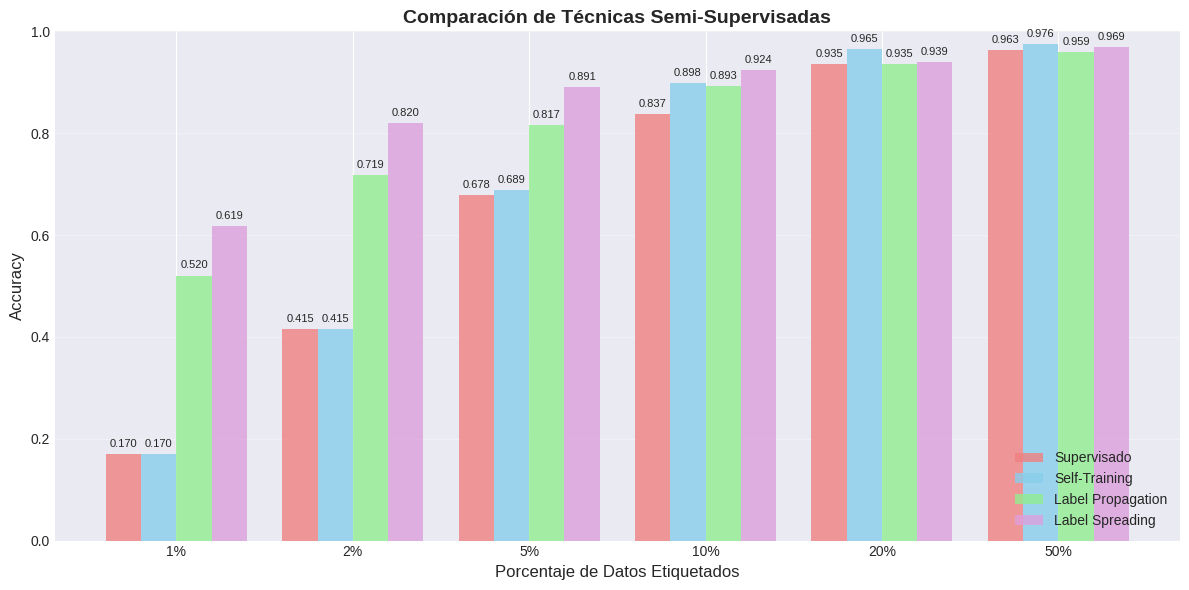

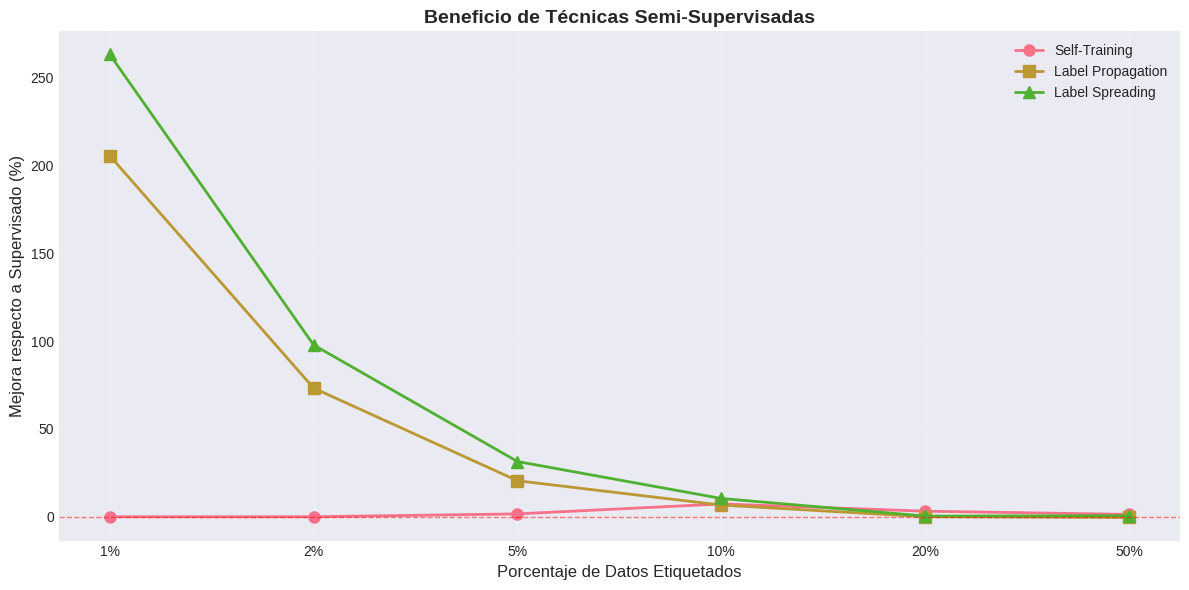

In [17]:


# Porcentajes de datos etiquetados a probar
porcentajes = [0.01, 0.02, 0.05, 0.10, 0.20, 0.50]
resultados_comparacion = []

for pct in porcentajes:
    n_lab = int(pct * len(X_train))

    # Crear dataset semi-supervisado
    y_semi_temp, idx_lab_temp = crear_dataset_semisupervisado(
        X_train_scaled, y_train, n_lab, random_state=SEED
    )

    print(f"Probando con {pct*100:.0f}% de datos etiquetados ({n_lab} ejemplos)")

    # 1. Modelo Supervisado (baseline)
    clf_sup_temp = SVC(kernel='rbf', gamma='scale', probability=True, random_state=SEED)
    clf_sup_temp.fit(X_train_scaled[idx_lab_temp], y_train[idx_lab_temp])
    acc_sup_temp = accuracy_score(y_test, clf_sup_temp.predict(X_test_scaled))

    # 2. Self-Training
    clf_self_temp = SelfTrainingClassifier(
        estimator=SVC(kernel='rbf', gamma='scale', probability=True, random_state=SEED),
        threshold=0.75,
        max_iter=10,
        verbose=False
    )
    clf_self_temp.fit(X_train_scaled, y_semi_temp)
    acc_self_temp = accuracy_score(y_test, clf_self_temp.predict(X_test_scaled))

    # 3. Label Propagation - CORREGIDO PARA EVITAR WARNINGS
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        warnings.filterwarnings("ignore", category=RuntimeWarning)

        clf_lp_temp = LabelPropagation(kernel='rbf', gamma=1.0, max_iter=1000)
        clf_lp_temp.fit(X_train_scaled, y_semi_temp)
        acc_lp_temp = accuracy_score(y_test, clf_lp_temp.predict(X_test_scaled))

    # 4. Label Spreading - CORREGIDO PARA EVITAR WARNINGS
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        warnings.filterwarnings("ignore", category=RuntimeWarning)

        clf_ls_temp = LabelSpreading(kernel='rbf', gamma=1.0, alpha=0.2, max_iter=1000)
        clf_ls_temp.fit(X_train_scaled, y_semi_temp)
        acc_ls_temp = accuracy_score(y_test, clf_ls_temp.predict(X_test_scaled))

    # Guardar resultados
    resultados_comparacion.append({
        'Porcentaje Etiquetado': f'{pct*100:.0f}%',
        'N Etiquetados': n_lab,
        'Supervisado': acc_sup_temp,
        'Self-Training': acc_self_temp,
        'Label Propagation': acc_lp_temp,
        'Label Spreading': acc_ls_temp
    })

    print(f"  Supervisado:         {acc_sup_temp:.4f}")
    print(f"  Self-Training:       {acc_self_temp:.4f} ({(acc_self_temp-acc_sup_temp)*100:+.1f}%)")
    print(f"  Label Propagation:   {acc_lp_temp:.4f} ({(acc_lp_temp-acc_sup_temp)*100:+.1f}%)")
    print(f"  Label Spreading:     {acc_ls_temp:.4f} ({(acc_ls_temp-acc_sup_temp)*100:+.1f}%)")

# Visualización de resultados
df_resultados = pd.DataFrame(resultados_comparacion)
print("\n TABLA RESUMEN DE RESULTADOS")
print(df_resultados.to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(porcentajes)); width = 0.2

ax.bar(x - 1.5*width, df_resultados['Supervisado'], width, label='Supervisado', color='lightcoral', alpha=0.8)
ax.bar(x - 0.5*width, df_resultados['Self-Training'], width, label='Self-Training', color='skyblue', alpha=0.8)
ax.bar(x + 0.5*width, df_resultados['Label Propagation'], width, label='Label Propagation', color='lightgreen', alpha=0.8)
ax.bar(x + 1.5*width, df_resultados['Label Spreading'], width, label='Label Spreading', color='plum', alpha=0.8)

ax.set_xlabel('Porcentaje de Datos Etiquetados', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Comparación de Técnicas Semi-Supervisadas', fontsize=14, fontweight='bold')
ax.set_xticks(x); ax.set_xticklabels(df_resultados['Porcentaje Etiquetado'])
ax.legend(loc='lower right'); ax.grid(axis='y', alpha=0.3); ax.set_ylim(0, 1)

for i, pct in enumerate(porcentajes):
    for j, (col, offset) in enumerate([
        ('Supervisado', -1.5),
        ('Self-Training', -0.5),
        ('Label Propagation', 0.5),
        ('Label Spreading', 1.5)
    ]):
        val = df_resultados.loc[i, col]
        ax.text(i + offset*width, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('comparison_semisupervised.png', dpi=300, bbox_inches='tight')

# Gráfico de mejora respecto a supervisado
fig, ax = plt.subplots(figsize=(12, 6))
mejoras = df_resultados.copy()
for col in ['Self-Training', 'Label Propagation', 'Label Spreading']:
    mejoras[col] = (mejoras[col] - mejoras['Supervisado']) / mejoras['Supervisado'] * 100

ax.plot(mejoras['Porcentaje Etiquetado'], mejoras['Self-Training'], marker='o', linewidth=2, label='Self-Training', markersize=8)
ax.plot(mejoras['Porcentaje Etiquetado'], mejoras['Label Propagation'], marker='s', linewidth=2, label='Label Propagation', markersize=8)
ax.plot(mejoras['Porcentaje Etiquetado'], mejoras['Label Spreading'], marker='^', linewidth=2, label='Label Spreading', markersize=8)

ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Porcentaje de Datos Etiquetados', fontsize=12)
ax.set_ylabel('Mejora respecto a Supervisado (%)', fontsize=12)
ax.set_title('Beneficio de Técnicas Semi-Supervisadas', fontsize=14, fontweight='bold')
ax.legend(loc='best'); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('improvement_semisupervised.png', dpi=300, bbox_inches='tight')


## CONCLUSIONES Y MEJORES PRÁCTICAS

In [23]:
# Encontrar mejor modelo en diferentes escenarios
mejor_pocos = df_resultados.iloc[0]  # Con menos etiquetas
mejor_muchos = df_resultados.iloc[-1]  # Con más etiquetas

conclusiones = f"""
 RESUMEN DE RESULTADOS:

HALLAZGOS PRINCIPALES:

1. BENEFICIO DEL APRENDIZAJE SEMI-SUPERVISADO:

   Con POCOS datos etiquetados ({mejor_pocos['Porcentaje Etiquetado']}):
   - Supervisado:         {mejor_pocos['Supervisado']:.4f}
   - Self-Training:       {mejor_pocos['Self-Training']:.4f} ({(mejor_pocos['Self-Training']-mejor_pocos['Supervisado'])/mejor_pocos['Supervisado']*100:+.1f}%)
   - Label Propagation:   {mejor_pocos['Label Propagation']:.4f} ({(mejor_pocos['Label Propagation']-mejor_pocos['Supervisado'])/mejor_pocos['Supervisado']*100:+.1f}%)
   - Label Spreading:     {mejor_pocos['Label Spreading']:.4f} ({(mejor_pocos['Label Spreading']-mejor_pocos['Supervisado'])/mejor_pocos['Supervisado']*100:+.1f}%)

    El beneficio es MAYOR cuando hay MUY POCOS datos etiquetados

   Con MÁS datos etiquetados ({mejor_muchos['Porcentaje Etiquetado']}):
   - Supervisado:         {mejor_muchos['Supervisado']:.4f}
   - Self-Training:       {mejor_muchos['Self-Training']:.4f} ({(mejor_muchos['Self-Training']-mejor_muchos['Supervisado'])/mejor_muchos['Supervisado']*100:+.1f}%)
   - Label Propagation:   {mejor_muchos['Label Propagation']:.4f} ({(mejor_muchos['Label Propagation']-mejor_muchos['Supervisado'])/mejor_muchos['Supervisado']*100:+.1f}%)
   - Label Spreading:     {mejor_muchos['Label Spreading']:.4f} ({(mejor_muchos['Label Spreading']-mejor_muchos['Supervisado'])/mejor_muchos['Supervisado']*100:+.1f}%)

    Con más etiquetas, la diferencia se reduce

2. COMPARACIÓN DE TÉCNICAS:

   Self-Training:
    Simple de implementar
    Funciona con cualquier clasificador base
    Control mediante threshold de confianza
    Puede amplificar errores iniciales
    Proceso iterativo (más lento)

   Label Propagation:
    Usa toda la estructura de datos
    Solución directa (no iterativa)
    Robusto con buenos parámetros de kernel
    Costoso computacionalmente (matriz O(n²))
    No permite modificar etiquetas originales

   Label Spreading:
    Similar a Label Propagation
    Permite que etiquetas originales cambien (parámetro alpha)
    Más flexible y robusto al ruido
    También costoso computacionalmente

 CUÁNDO USAR APRENDIZAJE SEMI-SUPERVISADO:

 USAR cuando:
- Etiquetar datos es COSTOSO (dinero, tiempo, expertos)
- Tienes MUCHOS datos sin etiquetar disponibles
- Los datos cumplen suposiciones de smoothness/cluster
- Ratio etiquetados/no-etiquetados es < 10%
- La estructura de datos sin etiquetar es informativa

NO USAR cuando:
- Ya tienes suficientes datos etiquetados
- Los datos sin etiquetar son muy ruidosos
- Las clases no forman clusters claros
- El costo computacional es prohibitivo
- Necesitas garantías de rendimiento

ELECCIÓN DE TÉCNICA:

Self-Training:
 Cuando necesitas simplicidad
 Dataset pequeño o mediano
 Tienes clasificador base confiable
 Puedes ajustar threshold de confianza

Label Propagation/Spreading:
 Cuando la estructura de datos es importante
 Datos forman clusters claros
 Dataset no es demasiado grande (< 100k muestras)
 Necesitas solución no iterativa


"""

print(conclusiones)


 RESUMEN DE RESULTADOS:

HALLAZGOS PRINCIPALES:

1. BENEFICIO DEL APRENDIZAJE SEMI-SUPERVISADO:
   
   Con POCOS datos etiquetados (1%):
   - Supervisado:         0.1704
   - Self-Training:       0.1704 (+0.0%)
   - Label Propagation:   0.5204 (+205.4%)
   - Label Spreading:     0.6185 (+263.0%)
   
    El beneficio es MAYOR cuando hay MUY POCOS datos etiquetados

   Con MÁS datos etiquetados (50%):
   - Supervisado:         0.9630
   - Self-Training:       0.9759 (+1.3%)
   - Label Propagation:   0.9593 (-0.4%)
   - Label Spreading:     0.9685 (+0.6%)
   
    Con más etiquetas, la diferencia se reduce

2. COMPARACIÓN DE TÉCNICAS:

   Self-Training:
    Simple de implementar
    Funciona con cualquier clasificador base
    Control mediante threshold de confianza
    Puede amplificar errores iniciales
    Proceso iterativo (más lento)
   
   Label Propagation:
    Usa toda la estructura de datos
    Solución directa (no iterativa)
    Robusto con buenos parámetros de kernel
    Costoso

## REFERENCIAS

In [22]:

print("REFERENCIAS Y RECURSOS")


referencias = """
DOCUMENTACIÓN OFICIAL:

Scikit-learn Semi-Supervised Learning:
- https://scikit-learn.org/stable/modules/semi_supervised.html
- Guía completa de módulos semi-supervisados

Algoritmos Específicos:
- SelfTrainingClassifier:
  https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.SelfTrainingClassifier.html
- LabelPropagation:
  https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html
- LabelSpreading:
  https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html

 DATASETS UTILIZADOS:

Digits Dataset:
- https://scikit-learn.org/stable/datasets/toy_dataset.html#digits-dataset
- 1797 imágenes de dígitos escritos a mano (8x8 pixeles)
- 10 clases (0-9)

Make Moons:
- https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html
- Dataset sintético en forma de dos lunas entrelazadas
- Útil para visualizar fronteras de decisión

 PAPER:

1. "Semi-Supervised Learning Using Gaussian Fields and Harmonic Functions"
   - Zhu et al., 2003
   - Base teórica de Label Propagation
   - Link: http://mlg.eng.cam.ac.uk/zoubin/papers/zgl.pdf

2. "Learning from Labeled and Unlabeled Data with Label Propagation"
   - Zhu & Ghahramani, 2002
   - CMU-CALD-02-107
   - Link: http://pages.cs.wisc.edu/~jerryzhu/pub/CMU-CALD-02-107.pdf




 APLICACIONES REALES:

Computer Vision:
- Google's Semi-Supervised Learning for Image Classification
- Self-training en reconocimiento facial

Natural Language Processing:
- BERT y modelos pre-entrenados (transfer learning)
- Clasificación de texto con pocos ejemplos

Medical Imaging:
- Diagnóstico con pocas muestras etiquetadas
- Crítico donde etiquetado requiere médicos expertos

Fraud Detection:
- Detección de anomalías con casos limitados
- Uso de datos normales sin etiquetar

"""
print(referencias)

REFERENCIAS Y RECURSOS

DOCUMENTACIÓN OFICIAL:

Scikit-learn Semi-Supervised Learning:
→ https://scikit-learn.org/stable/modules/semi_supervised.html
→ Guía completa de módulos semi-supervisados

Algoritmos Específicos:
→ SelfTrainingClassifier:
  https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.SelfTrainingClassifier.html
→ LabelPropagation:
  https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html
→ LabelSpreading:
  https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html

 DATASETS UTILIZADOS:

Digits Dataset:
→ https://scikit-learn.org/stable/datasets/toy_dataset.html#digits-dataset
→ 1797 imágenes de dígitos escritos a mano (8x8 pixeles)
→ 10 clases (0-9)

Make Moons:
→ https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html
→ Dataset sintético en forma de dos lunas entrelazadas
→ Útil para visualizar fronteras de decisión

 PAPER:

1. "Semi-Supervised 